# Прогнозирование временных рядов при помощи машинного обучения

Что обсудим:

1. Генерация признаков
2. Обучение модели регрессии на сгенерированных признаках

## Предобработка временного ряда

Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Будем работать с данными о ежемесячной средней зарплате сотрудников некоторой компании.

In [2]:
ts_wage = pd.read_csv(
    'https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',
    sep=';',
    decimal='.',
    parse_dates=True,
    index_col='Month'
    )

ts_wage.head()

,Real wage
Month,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


In [3]:
ts_wage.shape

(289, 1)

Посмотрим как ведет себя временной ряд

<Axes: xlabel='Month'>

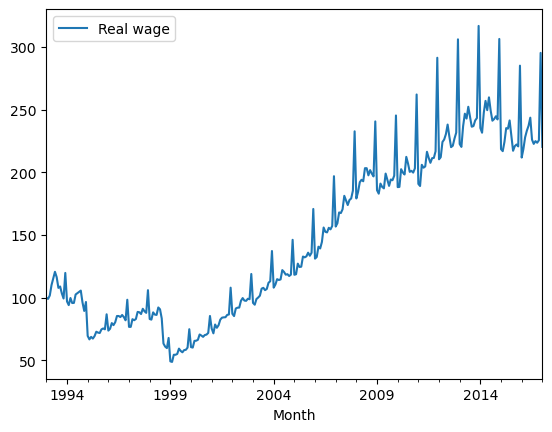

In [4]:
ts_wage.plot()

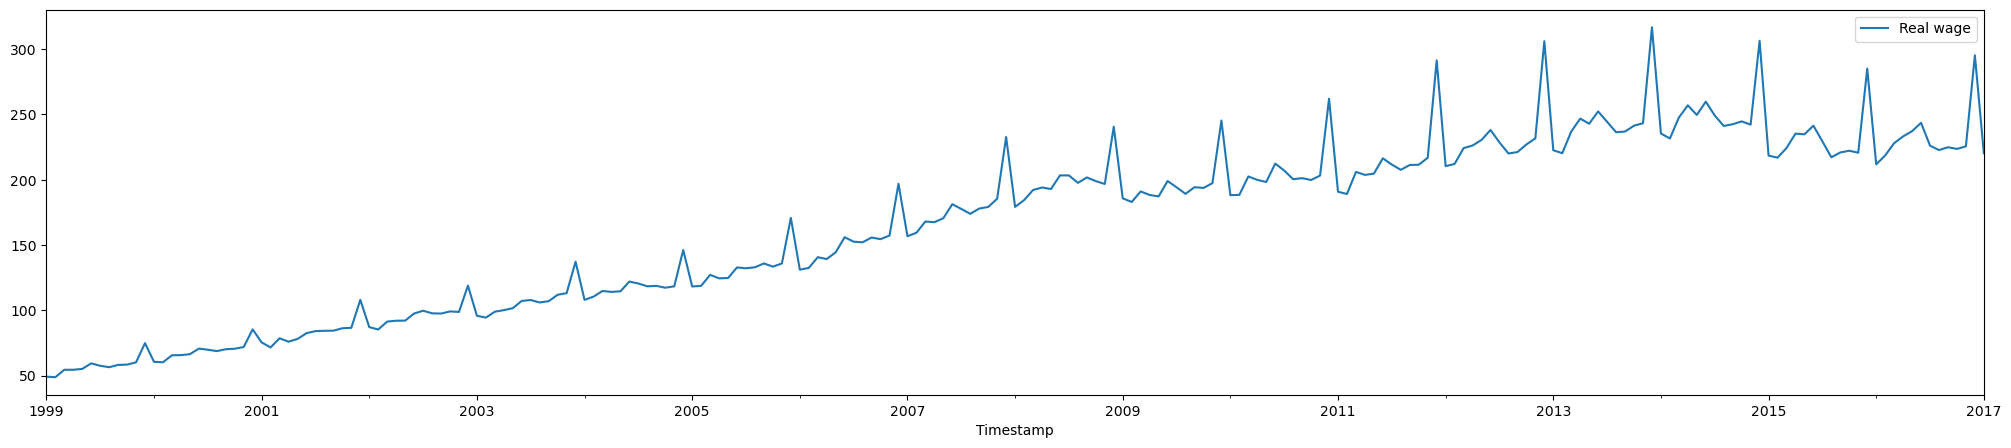

In [5]:
ts_wage.index.names=['Timestamp']
ts_wage = ts_wage.sort_index()

ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(25,5));

## Машинное обучение для прогнозирования временных рядов

### Что будет признаками для прогноза временного ряда?

### Лаговые признаки (lags)

Это значения ряда в предыдущие моменты времени.

Например, чтобы предсказать курс доллара сегодня ($y_t$), мы можем использовать значения курса доллара за последнюю неделю:

$$y_{t-1},y_{t-2},...,y_{t-7}.$$

Это и будут признаки.

In [6]:
ts_wage['Real wage'].shift(1)

Timestamp
1999-01-01       NaN
1999-02-01     49.22
1999-03-01     48.77
1999-04-01     54.48
1999-05-01     54.48
               ...  
2016-09-01    222.70
2016-10-01    224.90
2016-11-01    223.60
2016-12-01    225.60
2017-01-01    295.30
Name: Real wage, Length: 217, dtype: float64

In [7]:
for i in range(1, 8):
    ts_wage[f"lag_{i}"] = ts_wage['Real wage'].shift(i)

In [8]:
ts_wage.head()

,Real wage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Timestamp,,,,,,,,
1999-01-01,49.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-02-01,48.77,49.22,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-01,54.48,48.77,49.22,NaN,NaN,NaN,NaN,NaN
1999-04-01,54.48,54.48,48.77,49.22,NaN,NaN,NaN,NaN
1999-05-01,55.13,54.48,54.48,48.77,49.22,NaN,NaN,NaN


In [9]:
ts_wage.dropna(inplace=True)

ts_wage.head()

,Real wage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Timestamp,,,,,,,,
1999-08-01,56.45,57.54,59.38,55.13,54.48,54.48,48.77,49.22
1999-09-01,58.20,56.45,57.54,59.38,55.13,54.48,54.48,48.77
1999-10-01,58.43,58.20,56.45,57.54,59.38,55.13,54.48,54.48
1999-11-01,60.18,58.43,58.20,56.45,57.54,59.38,55.13,54.48
1999-12-01,74.87,60.18,58.43,58.20,56.45,57.54,59.38,55.13


### Разбиение на train и test для временных рядов

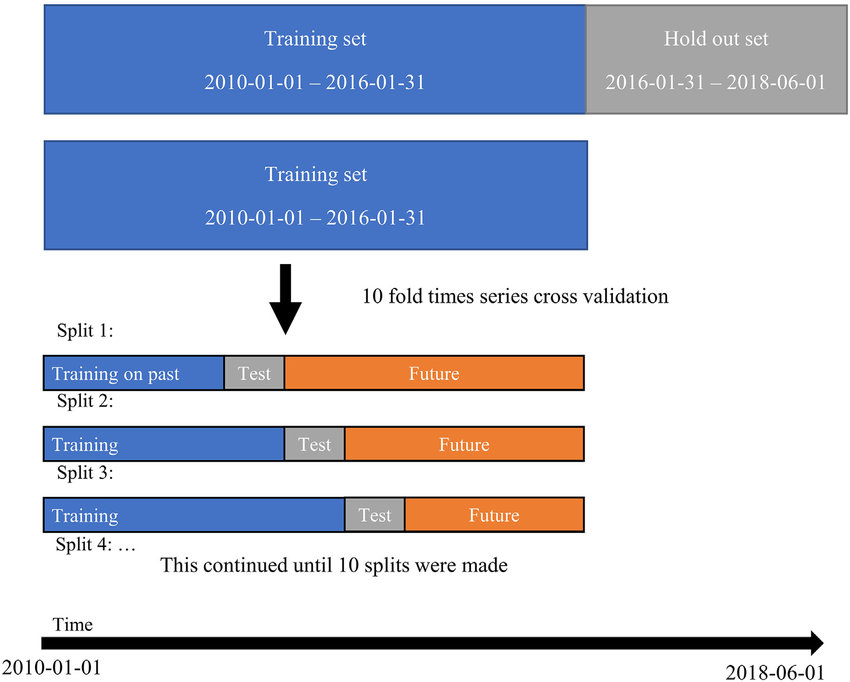

Разобъем данные на тренировочную и тестовую части.

In [10]:
Train = ts_wage.loc['01.01.1999':'31.12.2014']
Test = ts_wage.loc['01.01.2015':'01.01.2017']

Train.shape, Test.shape

((185, 8), (25, 8))

In [11]:
X_train = Train.drop('Real wage', axis=1)
y_train = Train['Real wage']

X_test = Test.drop('Real wage', axis=1)
y_test = Test['Real wage']

## Прогнозирование временных рядов

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

Обучим линейную регрессию:

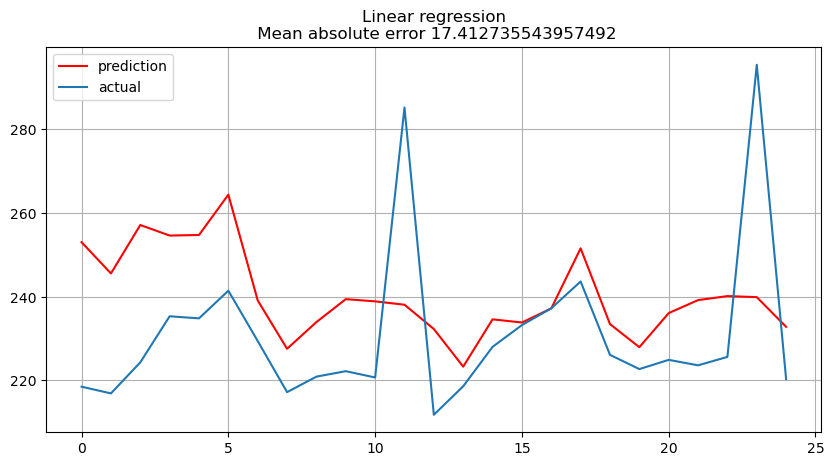

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)}");